In [605]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.colors as colors

import networkx as nx
import community as community_louvain

import folium
from folium.plugins import HeatMap
from folium.plugins import MarkerCluster, PolyLineTextPath
from collections import Counter

from datetime import datetime
import calendar
import holidays
import datetime

import os
import requests
from zipfile import ZipFile
from io import BytesIO

import ipywidgets as widgets
from IPython.display import display, clear_output, IFrame
import time
import asyncio

from html2image import Html2Image
import seaborn as sns

from scipy.stats import fligner
from scipy.stats import shapiro, bartlett, ttest_ind, mannwhitneyu

#### Open/Save data

In [606]:
tc = pd.read_csv('result/tc.csv')
data_all_uf = pd.read_csv('result/data_all.csv')
sp_trips_uf = pd.read_csv('result/sp_trips.csv')

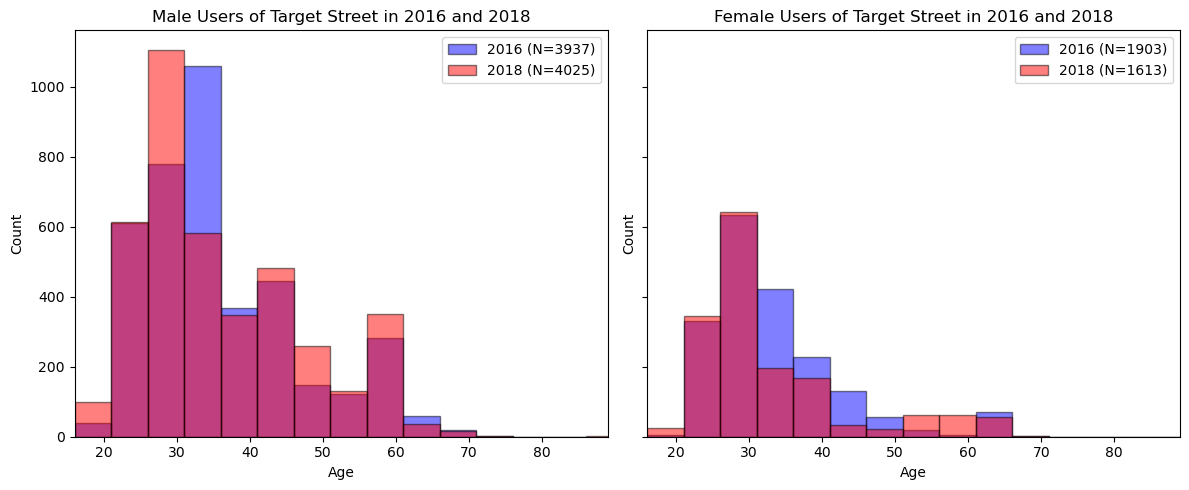

In [607]:
sp_trips_uf['age'] = sp_trips_uf['year'] - sp_trips_uf['birth year']
data_all_uf['age'] = data_all_uf['year'] - data_all_uf['birth year']

s18 = sp_trips_uf[sp_trips_uf['year'] == 2018].copy()
s16 = sp_trips_uf[sp_trips_uf['year'] == 2016].copy()

s18_male = s18[s18['gender'] == 1]
s16_male = s16[s16['gender'] == 1]
s18_female = s18[s18['gender'] == 2]
s16_female = s16[s16['gender'] == 2]

min_age = min(s16['age'].min(), s18['age'].min())
max_age = max(s16['age'].max(), s18['age'].max())
bins = range(min_age, max_age + 5, 5)

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

axes[0].hist(s16_male['age'], bins=bins, color='blue', edgecolor='black', alpha=0.5, label=f'2016 (N={len(s16_male)})')
axes[0].hist(s18_male['age'], bins=bins, color='red', edgecolor='black', alpha=0.5, label=f'2018 (N={len(s18_male)})')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Count')
axes[0].set_title('Male Users of Target Street in 2016 and 2018')
axes[0].legend()
axes[0].set_xlim(min_age, max_age)

axes[1].hist(s16_female['age'], bins=bins, color='blue', edgecolor='black', alpha=0.5, label=f'2016 (N={len(s16_female)})')
axes[1].hist(s18_female['age'], bins=bins, color='red', edgecolor='black', alpha=0.5, label=f'2018 (N={len(s18_female)})')
axes[1].set_xlabel('Age')
axes[1].set_ylabel('Count')
axes[1].set_title('Female Users of Target Street in 2016 and 2018')
axes[1].legend()
axes[1].set_xlim(min_age, max_age)

plt.tight_layout()
plt.show()

In [608]:
side_1 = [88,95,90,143,84,98,109,190,47,40,171]
side_2 = [70,73,74,180,96]

side_3 = np.unique([88,95,90,143,109,190,47,40,20,94,98,171,7,24,186,31,6,23,151,43,48,192,23,35,60,54]+[58,120,35,22,141,23]).tolist()
side_4 = [104,89,108,110]

side_5 = [88]
side_6 = [15,149]

side_right = np.unique(side_1 + side_3 + side_5).tolist()
side_left  = np.unique(side_2 + side_4 + side_6).tolist()
target_nodes =  np.unique(side_right + side_left)

In [609]:
# sp_trips = sp_trips[sp_trips['start station id'].isin(target_nodes) & sp_trips['end station id'].isin(target_nodes)]
data_all2 = data_all_uf[data_all_uf['start station id'].isin(target_nodes) & data_all_uf['end station id'].isin(target_nodes)]
tc2 = tc[tc['start station id'].isin(target_nodes) & tc['end station id'].isin(target_nodes)]

In [610]:
# ssummer = sp_trips[(sp_trips['month'].isin([6,7,8]))]

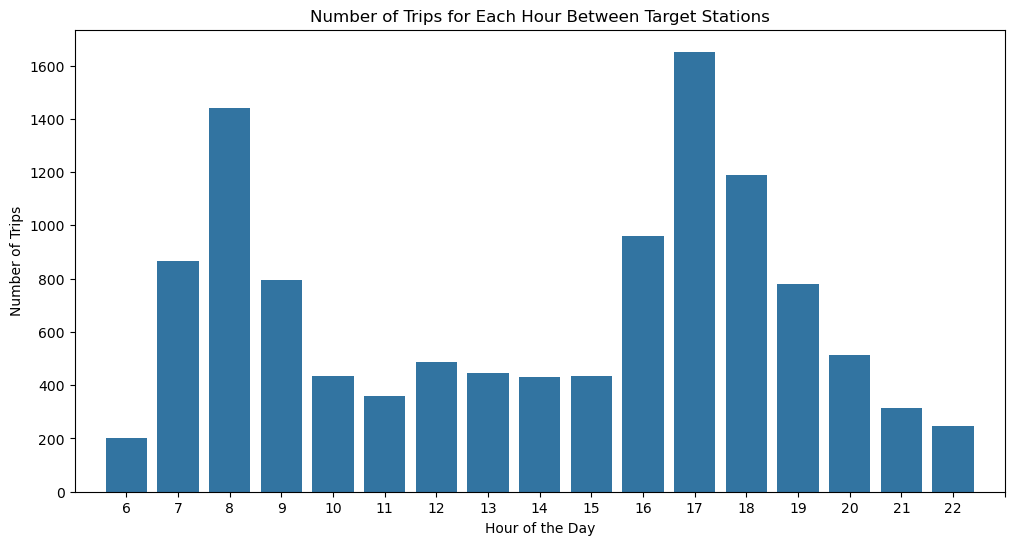

In [611]:
hourly_trip_counts = sp_trips_uf.groupby('hour').size().reset_index(name='trip_count')
# hourly_trip_counts = ssummer.groupby('hour').size().reset_index(name='trip_count')


plt.figure(figsize=(12, 6))
sns.barplot(x='hour', y='trip_count', data=hourly_trip_counts)

plt.xlabel('Hour of the Day')
plt.ylabel('Number of Trips')
plt.title('Number of Trips for Each Hour Between Target Stations')
plt.xticks(range(24))
plt.xlim(-1,17)
plt.show()

- <= 30: More risk-taking, younger individuals.
- 31 - 50: Likely active working individuals.
- 51 - 70: Older individuals.
- 70 < : Possibly incorrect or faked data.

---------------------------------------------------------------------------------------------

## Filter percipitation

In [612]:
percp_16 = pd.read_csv('percp_16_cam.csv')
percp_18 = pd.read_csv('percp_18_cam.csv')

percp_16['date'] = pd.to_datetime(percp_16[['year', 'month', 'day']])
percp_16 = percp_16[percp_16['date'].dt.weekday < 5]
percp_16 = percp_16.drop(columns=['date'])

percp_18['date'] = pd.to_datetime(percp_18[['year', 'month', 'day']])
percp_18 = percp_18[percp_18['date'].dt.weekday < 5]
percp_18 = percp_18.drop(columns=['date'])

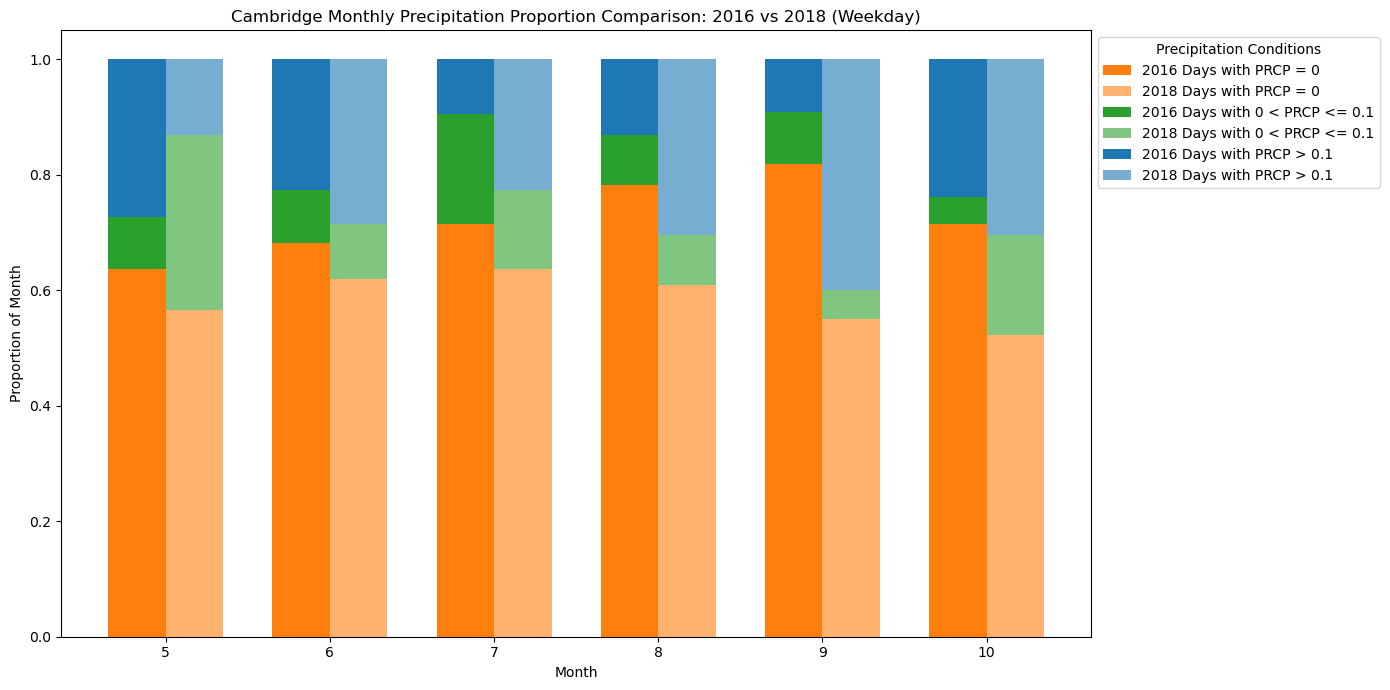

In [613]:
conditions = {
    'PRCP = 0': lambda x: x['PRCP (Inches)'] == 0,
    '0 < PRCP <= 0.1': lambda x: (x['PRCP (Inches)'] > 0) & (x['PRCP (Inches)'] <= 0.1),
    'PRCP > 0.1': lambda x: x['PRCP (Inches)'] > 0.1
}

labels = {
    'PRCP = 0': 'Days with PRCP = 0',
    '0 < PRCP <= 0.1': 'Days with 0 < PRCP <= 0.1',
    'PRCP > 0.1': 'Days with PRCP > 0.1'
}

color_map = {
    'PRCP = 0': 'tab:orange',
    '0 < PRCP <= 0.1': 'tab:green',
    'PRCP > 0.1': 'tab:blue'
}

counts_2016 = {condition: [] for condition in conditions}
counts_2018 = {condition: [] for condition in conditions}

total_days_2016 = percp_16.groupby('month').size()
total_days_2018 = percp_18.groupby('month').size()

for month in range(5, 11):
    percp_16_month = percp_16[percp_16['month'] == month]
    percp_18_month = percp_18[percp_18['month'] == month]
    for label, condition in conditions.items():
        counts_2016[label].append(percp_16_month[condition(percp_16_month)].shape[0] / total_days_2016[month])
        counts_2018[label].append(percp_18_month[condition(percp_18_month)].shape[0] / total_days_2018[month])

df_2016 = pd.DataFrame(counts_2016, index=range(5, 11))
df_2018 = pd.DataFrame(counts_2018, index=range(5, 11))

# Plotting
fig, ax = plt.subplots(figsize=(14, 7))
width = 0.35 

bottom_2016 = np.zeros(len(df_2016))
bottom_2018 = np.zeros(len(df_2018))

for condition, label in labels.items():
    color = color_map[condition]
    ax.bar(df_2016.index - width/2, df_2016[condition], width, bottom=bottom_2016, label=f'2016 {label}', color=color)
    ax.bar(df_2018.index + width/2, df_2018[condition], width, bottom=bottom_2018, label=f'2018 {label}', color=color, alpha=0.6)
    bottom_2016 += df_2016[condition]
    bottom_2018 += df_2018[condition]

ax.set_xlabel('Month')
ax.set_ylabel('Proportion of Month')
ax.set_title('Cambridge Monthly Precipitation Proportion Comparison: 2016 vs 2018 (Weekday)')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Precipitation Conditions')
plt.xticks(range(5, 11))
plt.tight_layout()
plt.show()


In [739]:
def filter_weather(sp_trips_df, percp_16, percp_18, months, hours, precip_threshold=0):
    sp_16 = sp_trips_df[sp_trips_df['year'] == 2016].copy()
    sp_18 = sp_trips_df[sp_trips_df['year'] == 2018].copy()

    sp_16 = pd.merge(sp_16, percp_16[['day', 'month', 'PRCP (Inches)']], on=['day', 'month'], how='left')
    sp_18 = pd.merge(sp_18, percp_18[['day', 'month', 'PRCP (Inches)']], on=['day', 'month'], how='left')

    # Merge with Boston precipitation data
    # sp_16 = pd.merge(sp_16, percp_16b[['day', 'month', 'PRCP (Inches)']], on=['day', 'month'], how='left', suffixes=('', '_boston'))
    # sp_18 = pd.merge(sp_18, percp_18b[['day', 'month', 'PRCP (Inches)']], on=['day', 'month'], how='left', suffixes=('', '_boston'))

    # Fill missing values with 100 (arbitrary big number to indicate no data)
    sp_16['PRCP (Inches)'] = sp_16['PRCP (Inches)'].fillna(100)
    sp_18['PRCP (Inches)'] = sp_18['PRCP (Inches)'].fillna(100)
    # sp_16['PRCP (Inches)_boston'] = sp_16['PRCP (Inches)_boston'].fillna(0)
    # sp_18['PRCP (Inches)_boston'] = sp_18['PRCP (Inches)_boston'].fillna(0)

    # sp_16_nice = sp_16[(sp_16['PRCP (Inches)'] <= 0.1) & (sp_16['PRCP (Inches)'] > precip_threshold)]
    # sp_18_nice = sp_18[(sp_18['PRCP (Inches)'] <= 0.1) & (sp_18['PRCP (Inches)'] > precip_threshold)]

    sp_16_nice = sp_16[(sp_16['PRCP (Inches)'] > 0)]
    sp_18_nice = sp_18[(sp_18['PRCP (Inches)'] > 0)]
    # sp_16_nice = sp_16[(sp_16['PRCP (Inches)'] == precip_threshold)]
    # sp_18_nice = sp_18[(sp_18['PRCP (Inches)'] == precip_threshold)]

    sp_16_nice = sp_16_nice[sp_16_nice['month'].isin(months) & sp_16_nice['hour'].isin(hours)]
    sp_18_nice = sp_18_nice[sp_18_nice['month'].isin(months) & sp_18_nice['hour'].isin(hours)]
    sp_trips_nice = pd.concat([sp_16_nice, sp_18_nice])

    return sp_16_nice, sp_18_nice, sp_trips_nice, sp_16, sp_18

In [740]:
months = range(5,13)
hours = range(6,23)
sp_16_nice, sp_18_nice, sp_trips, sp_16, sp_18 = filter_weather(sp_trips_uf, percp_16, percp_18, months, hours)
data_16_nice, data_18_nice, data_all, all_16, all_18= filter_weather(data_all_uf, percp_16, percp_18, months, hours)
# data_16_nice2, data_18_nice2, data_all_nice2, all_162, all_182= filter_weather(data_all, percp_16, percp_18, months, hours)

---------------------------------------

## Trips per day

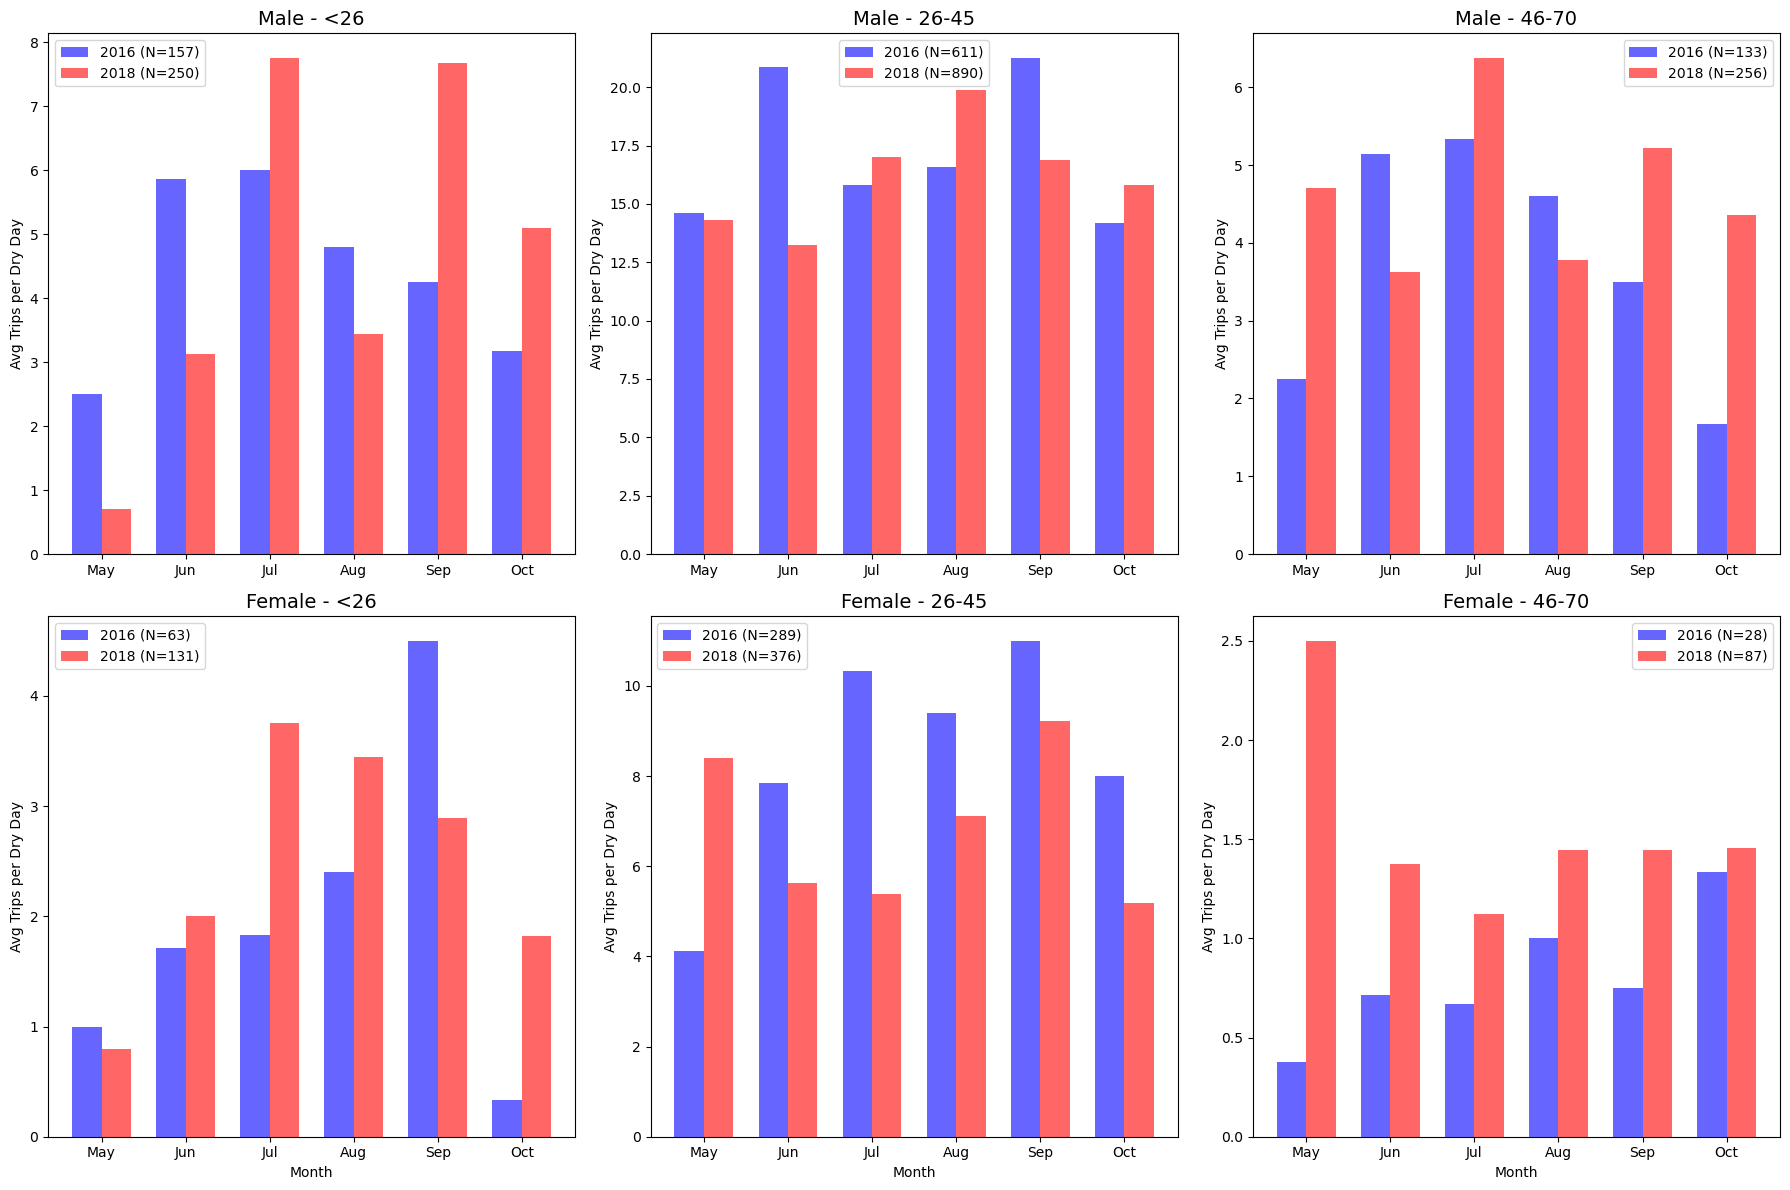

In [741]:
def categorize_age(age):
    if age < 26:
        return '<26'
    elif 26 <= age < 46:
        return '26-45'
    elif 46 <= age < 71:
        return '46-70'
    else:
        return None 

sp_trips['age_category'] = sp_trips['age'].apply(categorize_age)
sp_trips_filtered = sp_trips[(sp_trips['age_category'].notnull()) & (sp_trips['gender'].isin([1, 2]))]

sp_trips_2016 = sp_trips_filtered[sp_trips_filtered['year'] == 2016]
sp_trips_2018 = sp_trips_filtered[sp_trips_filtered['year'] == 2018]

# Function to calculate days without precipitation
def days_without_precipitation(df):
    return df[(df['PRCP (Inches)'] > 0) & (df['month'].between(5, 10))].groupby(['year', 'month']).size()

days_without_precip_2016 = days_without_precipitation(percp_16).reset_index(name='dry_days')
days_without_precip_2018 = days_without_precipitation(percp_18).reset_index(name='dry_days')

trips_per_month_2016 = sp_trips_2016[sp_trips_2016['month'].between(5, 10)].groupby(['month', 'age_category', 'gender']).size().reset_index(name='trips_per_month')
trips_per_month_2018 = sp_trips_2018[sp_trips_2018['month'].between(5, 10)].groupby(['month', 'age_category', 'gender']).size().reset_index(name='trips_per_month')

trips_per_month_2016 = pd.merge(trips_per_month_2016, days_without_precip_2016, on='month', how='left')
trips_per_month_2018 = pd.merge(trips_per_month_2018, days_without_precip_2018, on='month', how='left')

trips_per_month_2016['avg_trips_per_dry_day'] = trips_per_month_2016['trips_per_month'] / trips_per_month_2016['dry_days']
trips_per_month_2018['avg_trips_per_dry_day'] = trips_per_month_2018['trips_per_month'] / trips_per_month_2018['dry_days']

trips_per_month_2016['year'] = 2016
trips_per_month_2018['year'] = 2018

trips_combined = pd.concat([trips_per_month_2016, trips_per_month_2018])

month_labels = ['May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct']
colors = {'<26': 'blue', '26-45': 'orange', '46-70': 'green'}

# N
def calc_size(df, year, gender, age_category):
    return df[(df['year'] == year) & (df['gender'] == gender) & (df['age_category'] == age_category)]['trips_per_month'].sum()

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
for i, (gender, gender_label) in enumerate(zip([1, 2], ['Male', 'Female'])):
    for j, age_category in enumerate(['<26', '26-45', '46-70']):
        ax = axes[i, j]
        
        age_group_2016 = trips_combined[(trips_combined['age_category'] == age_category) & (trips_combined['year'] == 2016) & (trips_combined['gender'] == gender)].set_index('month')
        age_group_2018 = trips_combined[(trips_combined['age_category'] == age_category) & (trips_combined['year'] == 2018) & (trips_combined['gender'] == gender)].set_index('month')

        all_months = range(5, 11)
        age_group_2016 = age_group_2016.reindex(all_months, fill_value=0)
        age_group_2018 = age_group_2018.reindex(all_months, fill_value=0)
        
        width = 0.35 
        x = np.array(list(all_months)) - width / 2
        
        n_2016 = calc_size(trips_combined, 2016, gender, age_category)
        n_2018 = calc_size(trips_combined, 2018, gender, age_category)
        
        ax.bar(x, age_group_2016['avg_trips_per_dry_day'], width=width, label=f'2016 (N={n_2016})', color='blue', alpha=0.6)
        ax.bar(x + width, age_group_2018['avg_trips_per_dry_day'], width=width, label=f'2018 (N={n_2018})', color='red', alpha=0.6)
        
        ax.set_title(f'{gender_label} - {age_category}', fontsize=14)
        ax.set_xticks(range(5, 11))
        ax.set_xticklabels(month_labels)
        ax.set_ylabel('Avg Trips per Dry Day')
        ax.legend()
        
for ax in axes[1, :]:
    ax.set_xlabel('Month')

plt.tight_layout()
plt.show()


In [742]:
days_without_precip_2016

,year,month,dry_days
0,2016,5,8
1,2016,6,7
2,2016,7,6
3,2016,8,5
4,2016,9,4
5,2016,10,6


## Trips  Comparison 

In [743]:
def plot_trip_comparison(sp_trips, da, hour_range, title_suffix, month_range=range(5, 13)):
    
    def filter_data(year):
        return (sp_trips[(sp_trips['year'] == year) & (sp_trips['hour'].isin(hour_range)) & (sp_trips['month'].isin(month_range))],
                da[(da['year'] == year) & (da['hour'].isin(hour_range)) & (da['month'].isin(month_range))])
    
    t16, n16 = filter_data(2016)
    t18, n18 = filter_data(2018)
        
    def count_trips(data, dall, side_right, side_left):
        return (data[(data['start station id'].isin(side_right)) & (data['end station id'].isin(side_left))].shape[0],
                data[(data['start station id'].isin(side_left)) & (data['end station id'].isin(side_right))].shape[0],
                dall[(dall['start station id'].isin(side_right)) & (dall['end station id'].isin(side_right))].shape[0],
                dall[(dall['start station id'].isin(side_left)) & (dall['end station id'].isin(side_left))].shape[0])
    
    rl_16, lr_16, rr_16, ll_16 = count_trips(t16, n16, side_right, side_left)
    rl_18, lr_18, rr_18, ll_18 = count_trips(t18, n18, side_right, side_left)
    
    total_trips_16 = rl_16 + lr_16 + rr_16 + ll_16
    total_trips_18 = rl_18 + lr_18 + rr_18 + ll_18

    days_in_2016 = days_without_precip_2016['dry_days'].sum()
    
    avgt_2016 = {
        'rl': rl_16 / days_in_2016,
        'lr': lr_16 / days_in_2016,
        'rr': rr_16 / days_in_2016,
        'll': ll_16 / days_in_2016
    }

    growth_rl = ((rl_18 - rl_16) / total_trips_16) / avgt_2016['rl'] if total_trips_16 > 0 else 0
    growth_lr = ((lr_18 - lr_16) / total_trips_16) / avgt_2016['lr'] if total_trips_16 > 0 else 0
    growth_rr = ((rr_18 - rr_16) / total_trips_16) / avgt_2016['rr'] if total_trips_16 > 0 else 0
    growth_ll = ((ll_18 - ll_16) / total_trips_16) / avgt_2016['ll'] if total_trips_16 > 0 else 0

    waifw_matrix_16 = np.array([[ll_16, lr_16], [rl_16, rr_16]])
    waifw_matrix_18 = np.array([[ll_18, lr_18], [rl_18, rr_18]])
    growth_matrix = np.array([[growth_ll, growth_lr], [growth_rl, growth_rr]])

    def plot_heatmap(data, title, ax):
        sns.heatmap(data, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=.5, ax=ax)
        ax.set_title(title)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    plot_heatmap(pd.DataFrame(waifw_matrix_16, columns=['To_Left', 'To_Right'], index=['From_Left', 'From_Right']),
                 f'WAIFW 2016 Counts ({title_suffix})', axes[0])
    plot_heatmap(pd.DataFrame(waifw_matrix_18, columns=['To_Left', 'To_Right'], index=['From_Left', 'From_Right']),
                 f'WAIFW 2018 Counts ({title_suffix})', axes[1])
    plot_heatmap(pd.DataFrame(growth_matrix, columns=['To_Left', 'To_Right'], index=['From_Left', 'From_Right']),
                 f'Growth Rate Comparison ({title_suffix})', axes[2])
    plt.tight_layout()
    plt.show()

In [755]:
# sp_trips_nice = sp_trips[(sp_trips['gender']==2)&(sp_trips['age']<26)]
# data_all_nice = data_all[(data_all['gender']==2)&(data_all['age']<26)]
# sp_trips_nice = sp_trips[(sp_trips['gender']==2)&(sp_trips['age'].isin(range(26,46)))]
# data_all_nice = data_all[(data_all['gender']==2)&(data_all['age'].isin(range(26,46)))]

# sp_trips_nice = sp_trips[(sp_trips['gender']==2)&(sp_trips['age'].isin(range(46,71)))]
# data_all_nice = data_all[(data_all['gender']==2)&(data_all['age'].isin(range(46,71)))]

sp_trips_nice = sp_trips[(sp_trips['gender']==1)&(sp_trips['age']<=45)]
data_all_nice = data_all[(data_all['gender']==1)&(data_all['age']<=45)]

In [756]:
# plot_trip_comparison(sp_trips_nice, data_all_nice, range(7, 10), 'Morning Rush Hour')

In [757]:
# plot_trip_comparison(sp_trips_nice, data_all_nice, range(16, 20), 'Afternoon Rush Hour')

## WAIFW matrix

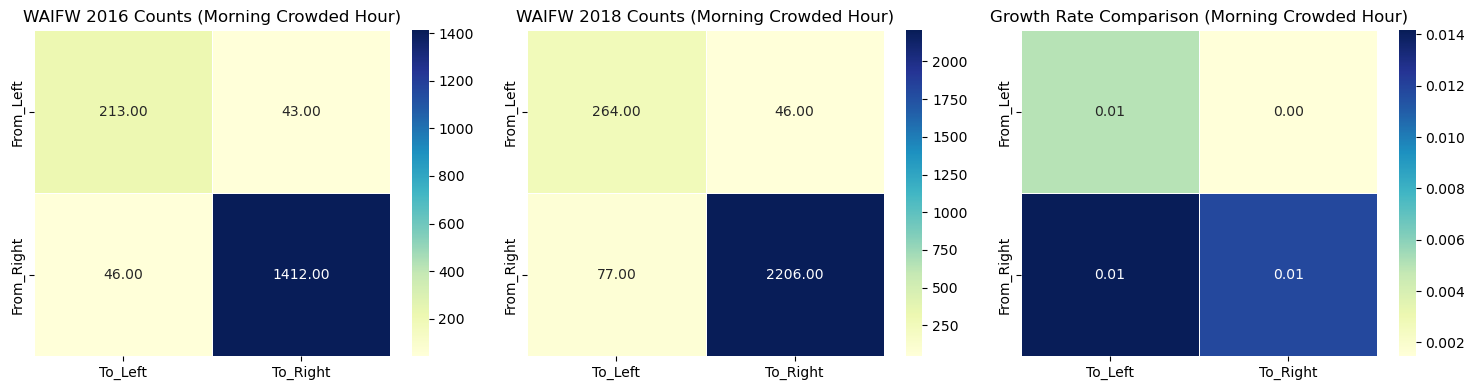

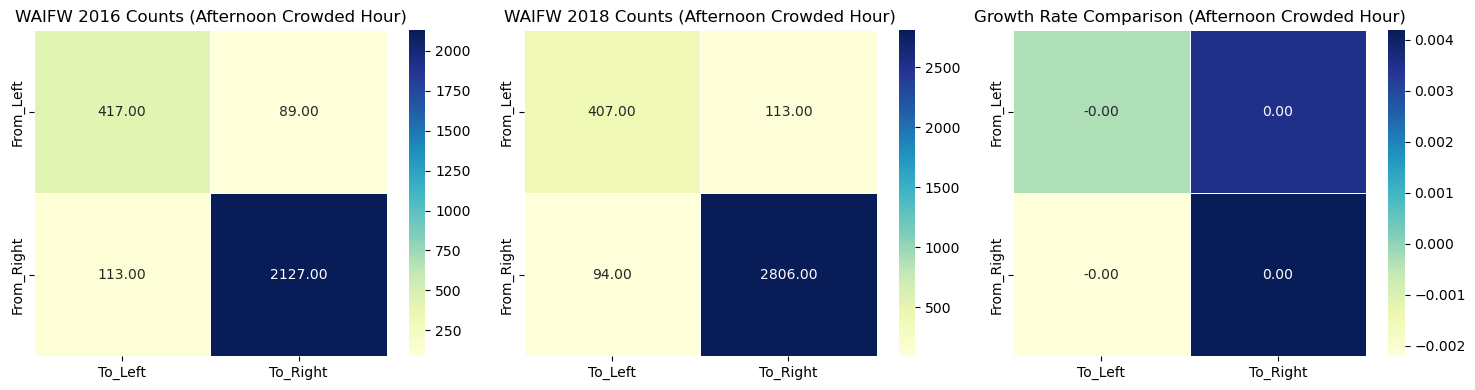

In [758]:
plot_trip_comparison(sp_trips_nice, data_all_nice, range(7, 10), 'Morning Crowded Hour', month_range=range(6, 9))
plot_trip_comparison(sp_trips_nice, data_all_nice, range(16, 20), 'Afternoon Crowded Hour', month_range=range(6, 9))

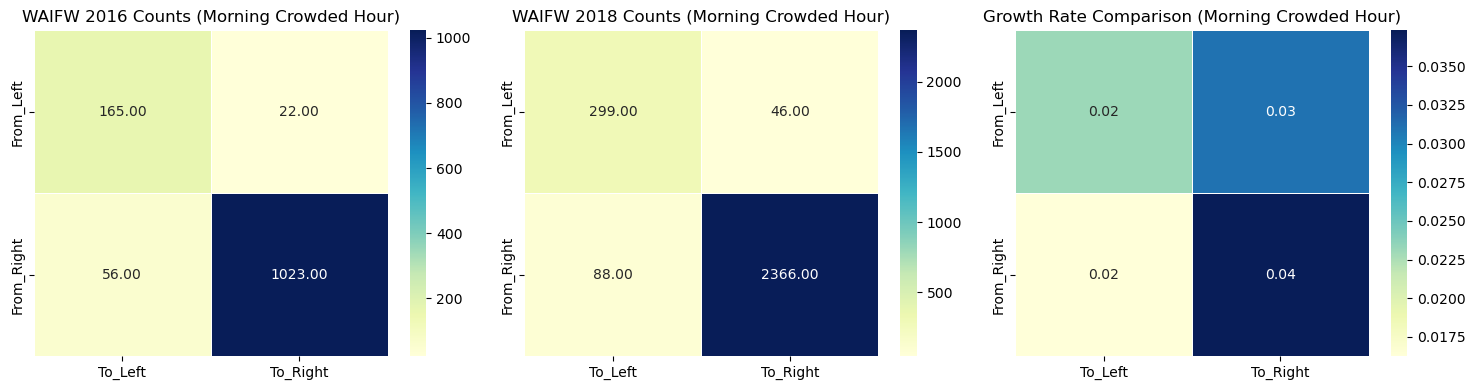

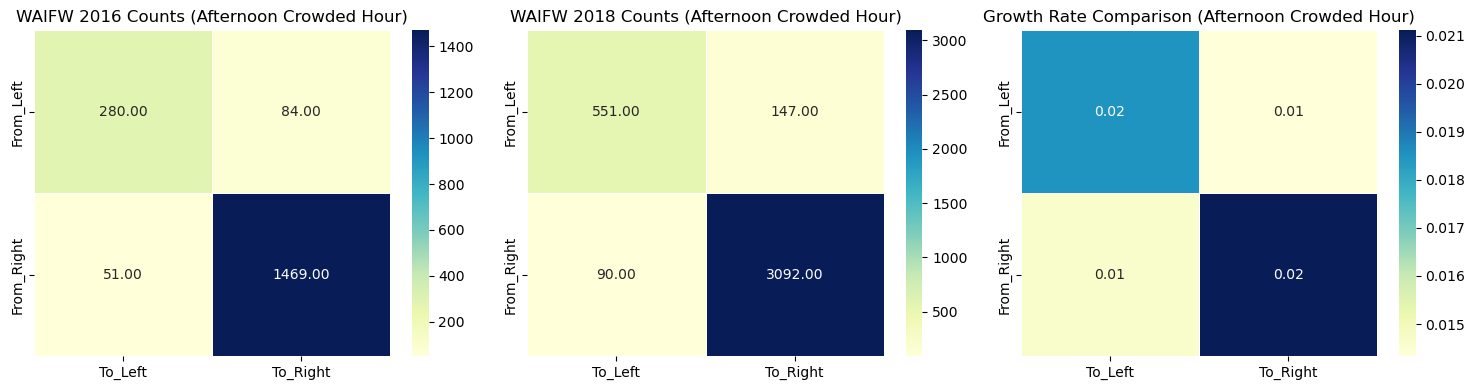

In [759]:
plot_trip_comparison(sp_trips_nice, data_all_nice, range(7, 10), 'Morning Crowded Hour', month_range=[5,9,10])
plot_trip_comparison(sp_trips_nice, data_all_nice, range(16, 20), 'Afternoon Crowded Hour', month_range=[5,9,10])

## Distance Analysis

In [545]:
def aggregate_time_groups(data, hours, months, year, median_calc = True, year_filt = True):
    start_hour = min(hours)
    end_hour = max(hours)
    

    filter_condition = (
        (data['hour'] >= start_hour) &
        (data['hour'] < end_hour) &
        (data['month'].isin(months))
    )
    if year_filt:
        filter_condition &= (data['year'] == year)

    filtered_data = data[filter_condition]
        
    if median_calc==True:
        aggregated_data = filtered_data.groupby(['start station id', 'end station id'])['median duration'].median().reset_index()
        return filtered_data, aggregated_data
    else:
        return filtered_data

In [320]:
trips_cam_dist = pd.read_csv("result/trips_cam_dist.csv")

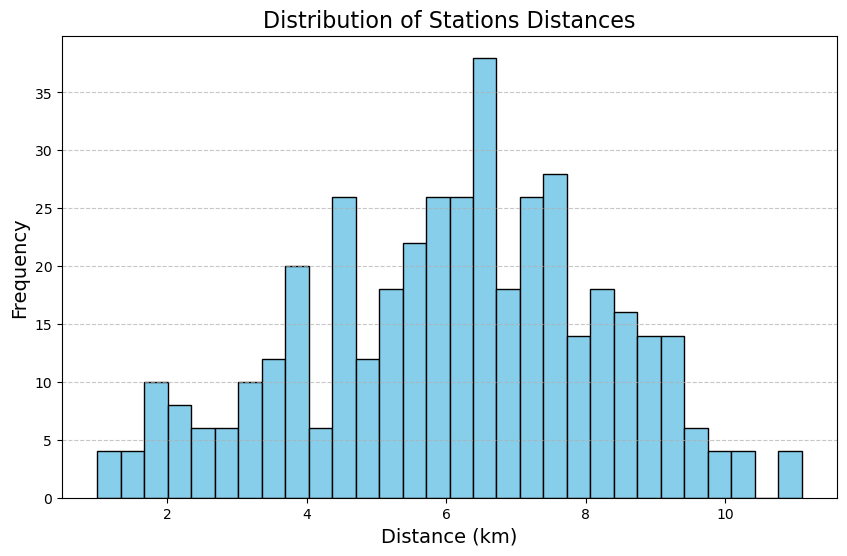

In [321]:
plt.figure(figsize=(10, 6))
plt.hist(trips_cam_dist['distance (km)'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Stations Distances', fontsize=16)
plt.xlabel('Distance (km)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [322]:
cam_all_unfilt = pd.merge(sp_trips_nice, trips_cam_dist[['start station id', 'end station id', 'distance (km)']], on=['start station id', 'end station id'], how='left')
cam_all_unfilt.head(1)

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,...,usertype,birth year,gender,hour,month,year,day,age,PRCP (Inches),distance (km)
0,990,2016-05-02 07:22:01,2016-05-02 07:38:32,109,TD Garden - Causeway at Portal Park #1,42.365942,-71.060515,110,Harvard University Gund Hall at Quincy St / Ki...,42.376369,...,Subscriber,1982,1,7,5,2016,2,34,0.12,5.5


In [323]:
num_rows_with_nan = cam_all_unfilt.isna().any(axis=1).sum()
print(f"Number of rows with NaN values: {num_rows_with_nan}")

Number of rows with NaN values: 0


In [367]:
hour =  range(7,11)
# hour =  range(16,21)

month = range(6,9)
# month = [5,9,10]

plot_data_dist_speed = cam_all_unfilt
cam_all = aggregate_time_groups(plot_data_dist_speed, hour, month, None, median_calc = False, year_filt=False)

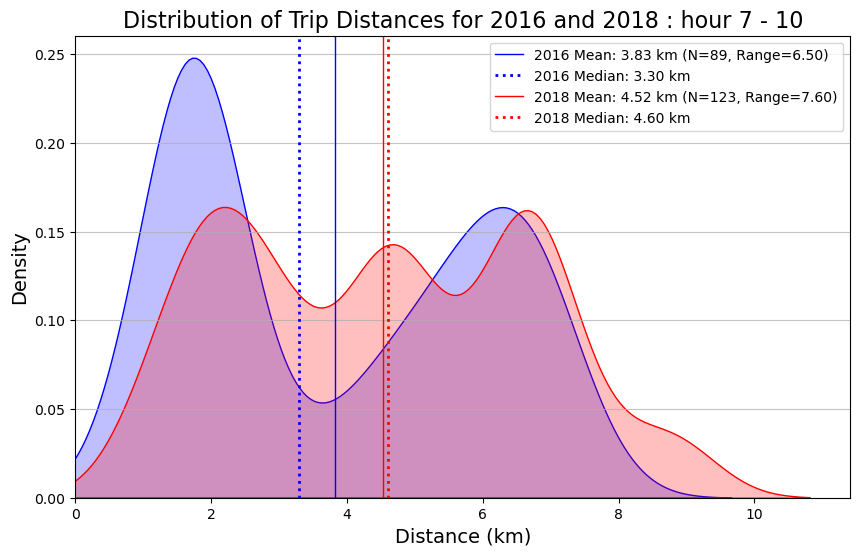

In [368]:
from scipy.signal import find_peaks

def get_peaks(data, column, num_peaks=3):
    kde = sns.kdeplot(data[column], bw_adjust=0.8)
    kde_data = kde.get_lines()[0].get_data()
    plt.close() 
    
    peaks, _ = find_peaks(kde_data[1])
    peak_values = kde_data[0][peaks]
    peak_densities = kde_data[1][peaks]
    sorted_peaks = sorted(zip(peak_densities, peak_values), reverse=True)
    
    return [(round(peak[1], 2), round(peak[0], 2)) for peak in sorted_peaks[:num_peaks]]

cam_2016 = cam_all[cam_all['year'] == 2016]
cam_2018 = cam_all[cam_all['year'] == 2018]

peaks_2016 = get_peaks(cam_2016, 'distance (km)')
peaks_2018 = get_peaks(cam_2018, 'distance (km)')


plt.figure(figsize=(10, 6))

sns.kdeplot(cam_2016['distance (km)'], color='blue', linestyle='-', fill=True, bw_adjust=0.8)
sns.kdeplot(cam_2018['distance (km)'], color='red', linestyle='-', fill=True, bw_adjust=0.8)
plt.title(f'Distribution of Trip Distances for 2016 and 2018 : hour {min(hour)} - {max(hour)}', fontsize=16)
plt.xlabel('Distance (km)', fontsize=14)
plt.ylabel('Density', fontsize=14)

# Statistics for 2016
mean_distance_2016 = cam_2016['distance (km)'].mean()
median_distance_2016 = cam_2016['distance (km)'].median()
std_distance_2016 = cam_2016['distance (km)'].std()
count_2016 = cam_2016.shape[0]
data_range_2016 = cam_2016['distance (km)'].max() - cam_2016['distance (km)'].min()

plt.axvline(mean_distance_2016, color='blue', linestyle='solid', linewidth=1, label=f'2016 Mean: {mean_distance_2016:.2f} km (N={count_2016}, Range={data_range_2016:.2f})')
plt.axvline(median_distance_2016, color='blue', linestyle='dotted', linewidth=2, label=f'2016 Median: {median_distance_2016:.2f} km')

# Statistics for 2018
mean_distance_2018 = cam_2018['distance (km)'].mean()
median_distance_2018 = cam_2018['distance (km)'].median()
std_distance_2018 = cam_2018['distance (km)'].std()
count_2018 = cam_2018.shape[0]
data_range_2018 = cam_2018['distance (km)'].max() - cam_2018['distance (km)'].min()

plt.axvline(mean_distance_2018, color='red', linestyle='solid', linewidth=1, label=f'2018 Mean: {mean_distance_2018:.2f} km (N={count_2018}, Range={data_range_2018:.2f})')
plt.axvline(median_distance_2018, color='red', linestyle='dotted', linewidth=2, label=f'2018 Median: {median_distance_2018:.2f} km')

plt.grid(axis='y', alpha=0.75)
# plt.legend(title=f'2016 Peaks: {peaks_2016}\n2018 Peaks: {peaks_2018}')
plt.legend()
plt.xlim(0, None)  # Adjust x-axis limits to start from 0
plt.show()

In [369]:
print("2016 Peaks:", peaks_2016)
print("2018 Peaks:", peaks_2018)
print("Range diff:", np.round(data_range_2018-data_range_2016,2))

2016 Peaks: [(1.72, 0.25), (6.29, 0.16)]
2018 Peaks: [(2.22, 0.16), (6.67, 0.16), (4.68, 0.14)]
Range diff: 1.1


In [370]:
from scipy.stats import ks_2samp

ks_stat, ks_p_val = ks_2samp(cam_2016['distance (km)'], cam_2018['distance (km)'])
print(f'Kolmogorov-Smirnov Test: Statistic={ks_stat}, p-value={ks_p_val}')
if ks_p_val < 0.05:
    print("The p-value is less than 0.05, indicating  A STATISTICALLY SIGNIFICANT difference between the 2016 and 2018 distributions.")
else:
    print("The p-value is greater than 0.05, indicating NO statistically significant difference between the 2016 and 2018 distributions.")

Kolmogorov-Smirnov Test: Statistic=0.2662829999086508, p-value=0.0009905963300122337
The p-value is less than 0.05, indicating  A STATISTICALLY SIGNIFICANT difference between the 2016 and 2018 distributions.


In [371]:
from scipy.stats import mannwhitneyu

u_stat, p_val = mannwhitneyu(cam_2016['distance (km)'] , cam_2018['distance (km)'])
print(f'U-statistic: {u_stat}, p-value: {p_val}')

if p_val < 0.05:
    print("The p-value is less than 0.05, indicating A STATISTICALLY SIGNIFCANT difference between the 2016 and 2018 distributions. You can compare the medians.")
else:
    print("The p-value is greater than 0.05, indicating NO statistically significant difference between the 2016 and 2018 distributions. Comparing the medians is not appropriate.")

U-statistic: 4384.0, p-value: 0.013372541541060145
The p-value is less than 0.05, indicating A STATISTICALLY SIGNIFCANT difference between the 2016 and 2018 distributions. You can compare the medians.


## Speed Analysis

In [383]:
short_boundary = 1.6
long_boundary = 6

In [384]:
cam_all = cam_all.copy()
cam_all['speed (km/h)'] = cam_all['distance (km)']/ (cam_all['tripduration']/3600)
cam_all = cam_all[(cam_all['speed (km/h)'] <= 32)]
cam_all = cam_all[(cam_all['speed (km/h)'] >= 5)]
cam_all = cam_all.drop_duplicates()

In [385]:
# divide short (<1.5 km), med, and long trip 
cam_short = cam_all[cam_all['distance (km)']<short_boundary]
cam_med = cam_all[((cam_all['distance (km)']>=short_boundary)&(cam_all['distance (km)']<=long_boundary))]
cam_long = cam_all[cam_all['distance (km)']>long_boundary]

In [386]:
def plot_speed(data, title, typ='cumsum', ax=None):
    colors = {2016: 'blue', 2018: 'red'}

    # Calculate combined bin edges
    combined_speed_data = data['speed (km/h)']
    _, combined_bin_edges = np.histogram(combined_speed_data, bins=15)
    min_speed = combined_bin_edges.min()
    max_speed = combined_bin_edges.max()
    
    for year in [2016, 2018]:
        speed_data = data[data['year'] == year]['speed (km/h)']
        num_points = len(speed_data)

        if typ == 'density':
            sns.kdeplot(speed_data, color=colors[year], fill=True, warn_singular=False, label=f'{year} (n={num_points})', ax=ax)
            ax.set_ylabel('Density', fontsize=12)

        elif typ == 'freq':            
            ax.hist(speed_data, bins=combined_bin_edges, color=colors[year], alpha=0.5, edgecolor='black', label=f'{year} (n={num_points})', density=True)
            # ax.set_ylabel('Frequency', fontsize=12)

        elif typ == 'cumsum':
            sns.ecdfplot(speed_data, color=colors[year], linestyle='-', linewidth=2, label=f'{year} (n={num_points})', ax=ax)
            ax.set_ylabel('Cumulative Sum (Normalized)', fontsize=12)
        
        mean_speed = data[data['year'] == year]['speed (km/h)'].mean()
        median_speed = data[data['year'] == year]['speed (km/h)'].median()
        ax.axvline(mean_speed, color=colors[year], linestyle='solid', linewidth=1, label=f'Mean: {mean_speed:.2f} km/h')
        ax.axvline(median_speed, color=colors[year], linestyle='dashed', linewidth=1, label=f'Median: {median_speed:.2f} km/h')

    ax.set_title(title, fontsize=12)
    ax.legend(fontsize=10)
    ax.grid(axis='y', alpha=0.75)
    ax.set_xlim(min_speed, max_speed)

C:\Users\nadil\AppData\Local\Temp\ipykernel_84540\62220886.py:13: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0.01, 0.01, 0.05, 0.01])


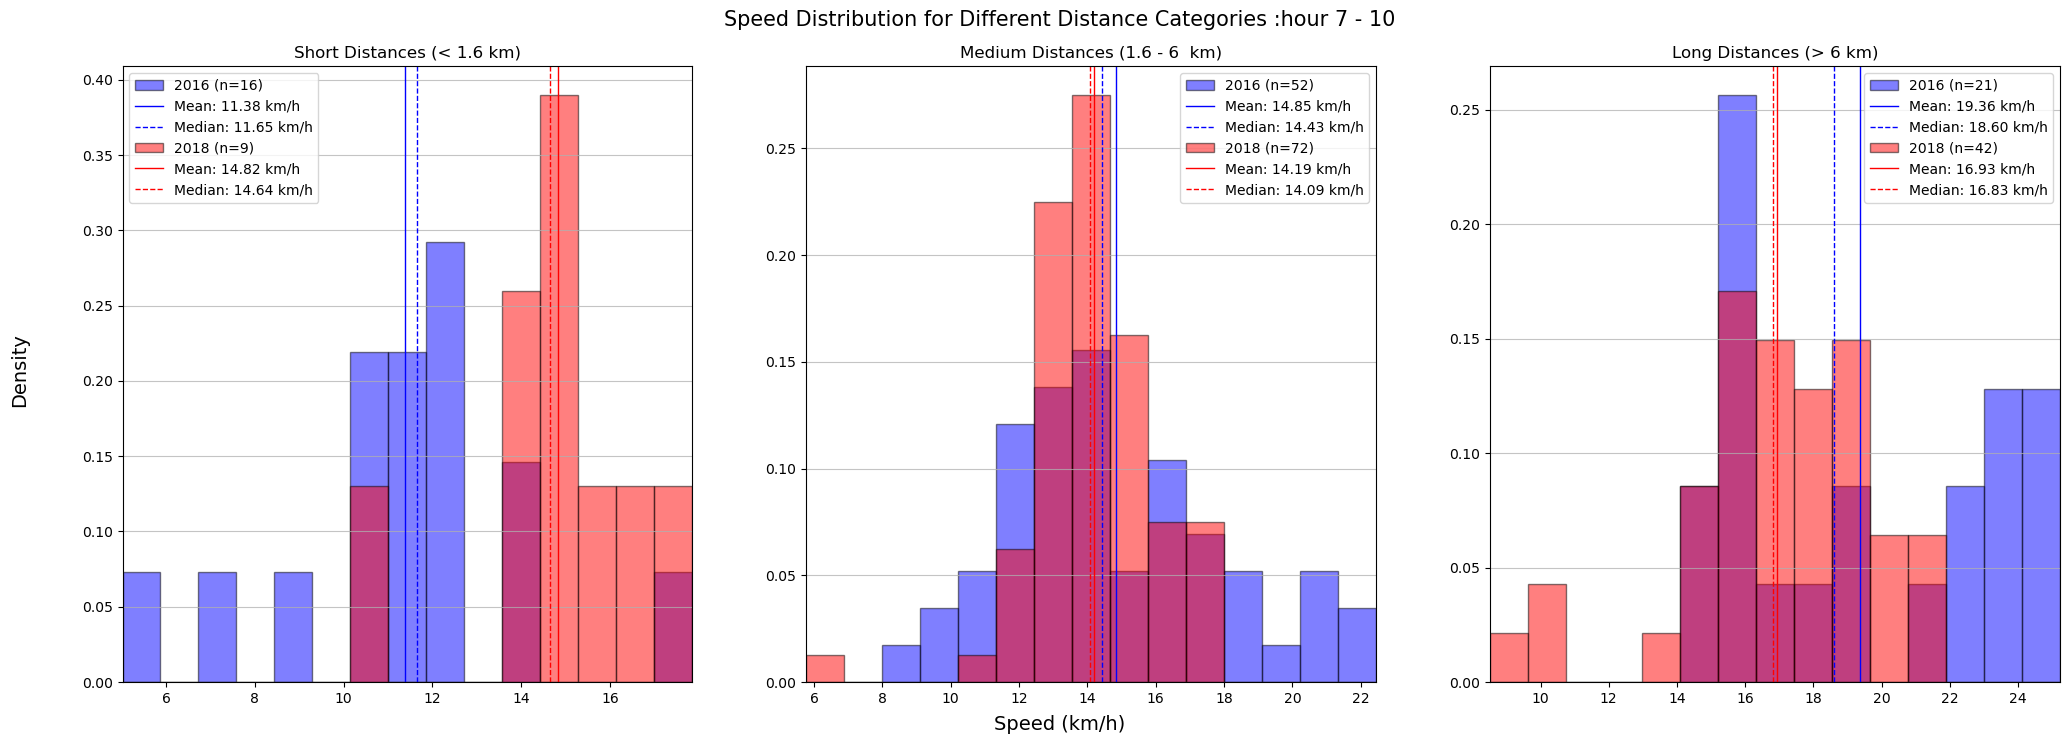

In [387]:
fig, axes =  plt.subplots(1, 3, figsize=(25, 8))
typ ='freq'
plot_speed(cam_short, f'Short Distances (< {short_boundary} km)', typ, ax=axes[0])
plot_speed(cam_med, f'Medium Distances ({short_boundary} - {long_boundary}  km)', typ, ax=axes[1])

plot_speed(cam_long, f'Long Distances (> {long_boundary} km)', typ, ax=axes[2])
# plot_speed(cam_all, f'All', typ, ax=axes[1, 1])

fig.suptitle(f'Speed Distribution for Different Distance Categories :hour {min(hour)} - {max(hour)}', fontsize=15, y=0.95)
fig.text(0.5, 0.05, 'Speed (km/h)', ha='center', fontsize=14)
fig.text(0.08, 0.5, 'Density', va='center', rotation='vertical', fontsize=14)

plt.tight_layout(rect=[0.01, 0.01, 0.05, 0.01])
plt.show()

In [388]:
short_distances = cam_short 
medium_distances = cam_med
long_distances = cam_long

# Perform Fligner-Killeen test for each year
fligner_test_2016 = fligner(short_distances[short_distances['year'] == 2016]['speed (km/h)'],
                            medium_distances[medium_distances['year'] == 2016]['speed (km/h)'],
                            long_distances[long_distances['year'] == 2016]['speed (km/h)'])

fligner_test_2018 = fligner(short_distances[short_distances['year'] == 2018]['speed (km/h)'],
                            medium_distances[medium_distances['year'] == 2018]['speed (km/h)'],
                            long_distances[long_distances['year'] == 2018]['speed (km/h)'])

print('Fligner-Killeen Test for 2016:')
print(f'Statistic: {fligner_test_2016.statistic}, p-value: {fligner_test_2016.pvalue}')
if fligner_test_2016.pvalue<0.05:
    print("DO NOT combine")
else:
    print("CAN combine")
    
print('\nFligner-Killeen Test for 2018:')
print(f'Statistic: {fligner_test_2018.statistic}, p-value: {fligner_test_2018.pvalue}')
if fligner_test_2018.pvalue<0.05:
    print("DO NOT combine")
else:
    print("CAN combine")


Fligner-Killeen Test for 2016:
Statistic: 5.045135198448699, p-value: 0.08025328371643055
CAN combine

Fligner-Killeen Test for 2018:
Statistic: 9.827343189955144, p-value: 0.007345469172295617
DO NOT combine


In [389]:
def compare_distributions(data_2016, data_2018, column, med=True):

    data_2016 = data_2016[column]
    data_2018 = data_2018[column]
    
    if med:
        # Use Mann-Whitney U test for non-parametric comparison of medians
        u_stat, u_p_val = mannwhitneyu(data_2016, data_2018)
        print(f'Mann-Whitney U Test: U-statistic={u_stat}, p-value={u_p_val}')
        if u_p_val < 0.05:
            print("The p-value is less than 0.05, indicating a statistically significant difference between the 2016 and 2018 medians.")
        else:
            print("The p-value is greater than 0.05, indicating NO statistically significant difference between the 2016 and 2018 medians.")
    else:
        # Check for normality
        shapiro_test_2016 = shapiro(data_2016)
        shapiro_test_2018 = shapiro(data_2018)
        
        print(f'Shapiro-Wilk Test for 2016: Statistic={shapiro_test_2016.statistic}, p-value={shapiro_test_2016.pvalue}')
        print(f'Shapiro-Wilk Test for 2018: Statistic={shapiro_test_2018.statistic}, p-value={shapiro_test_2018.pvalue}')
        
        normality_2016 = shapiro_test_2016.pvalue > 0.05
        normality_2018 = shapiro_test_2018.pvalue > 0.05

        # Comment on normality
        if normality_2016:
            print("The distribution for 2016 is normal.")
        else:
            print("The distribution for 2016 is not normal.")
        
        if normality_2018:
            print("The distribution for 2018 is normal.")
        else:
            print("The distribution for 2018 is not normal.")
        
        if normality_2016 and normality_2018:
            # Check for homogeneity of variances
            bartlett_test = bartlett(data_2016, data_2018)
            print(f'Bartlett Test: Statistic={bartlett_test.statistic}, p-value={bartlett_test.pvalue}')
            
            # If p-value > 0.05, we assume equal variances
            equal_variances = bartlett_test.pvalue > 0.05
            
            if equal_variances:
                t_stat, p_val = ttest_ind(data_2016, data_2018, equal_var=True)
                print(f'Independent t-test: t-statistic={t_stat}, p-value={p_val}')
                if p_val < 0.05:
                    print("The p-value is less than 0.05, indicating a statistically significant difference between the 2016 and 2018 means.")
                else:
                    print("The p-value is greater than 0.05, indicating NO statistically significant difference between the 2016 and 2018 means.")
            else:
                t_stat, p_val = ttest_ind(data_2016, data_2018, equal_var=False)
                print(f'Welch’s t-test: t-statistic={t_stat}, p-value={p_val}')
                if p_val < 0.05:
                    print("The p-value is less than 0.05, indicating a statistically significant difference between the 2016 and 2018 means.")
                else:
                    print("The p-value is greater than 0.05, indicating NO statistically significant difference between the 2016 and 2018 means.")
        else:
            # Use Mann-Whitney U test for non-parametric comparison
            u_stat, u_p_val = mannwhitneyu(data_2016, data_2018)
            print(f'Mann-Whitney U Test: U-statistic={u_stat}, p-value={u_p_val}')
            if u_p_val < 0.05:
                print("The p-value is less than 0.05, indicating a statistically significant difference between the 2016 and 2018 distributions. You can compare the medians.")
            else:
                print("The p-value is greater than 0.05, indicating NO statistically significant difference between the 2016 and 2018 distributions. Comparing the medians is not appropriate.")

In [390]:
compare_distributions(short_distances[short_distances['year'] == 2016], short_distances[short_distances['year'] == 2018], 'speed (km/h)', med=True)

Mann-Whitney U Test: U-statistic=18.0, p-value=0.002454937957197063
The p-value is less than 0.05, indicating a statistically significant difference between the 2016 and 2018 medians.


In [391]:
compare_distributions(medium_distances[medium_distances['year'] == 2016], medium_distances[medium_distances['year'] == 2018], 'speed (km/h)', med=True)

Mann-Whitney U Test: U-statistic=1965.0, p-value=0.6395022105578055
The p-value is greater than 0.05, indicating NO statistically significant difference between the 2016 and 2018 medians.


In [392]:
compare_distributions(long_distances[long_distances['year'] == 2016], long_distances[long_distances['year'] == 2018], 'speed (km/h)', med=True)

Mann-Whitney U Test: U-statistic=557.0, p-value=0.09217308675115994
The p-value is greater than 0.05, indicating NO statistically significant difference between the 2016 and 2018 medians.


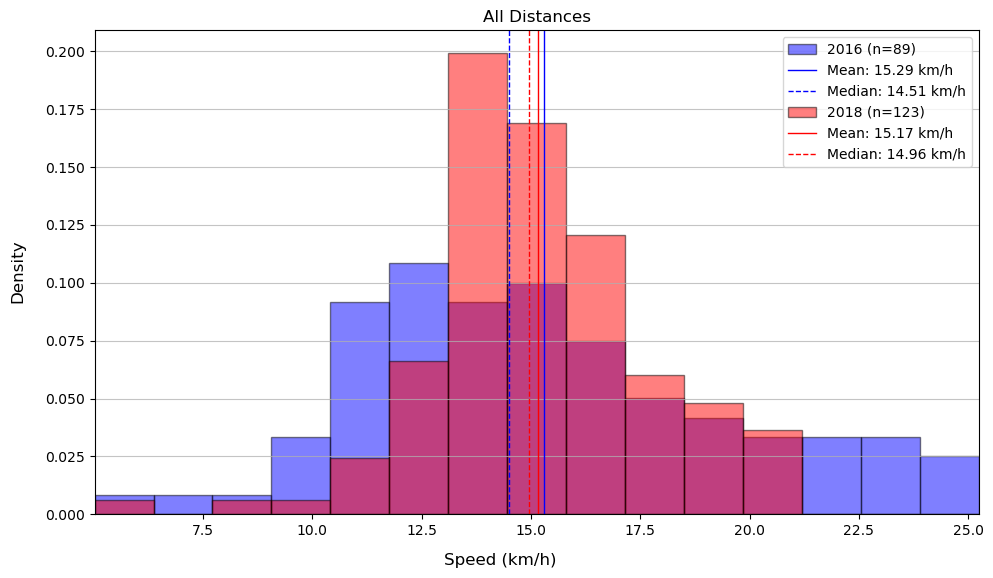

In [382]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_speed(cam_all, 'All Distances', typ='freq', ax=ax)

# fig.suptitle('Speed Distribution for All Distances : hour 7 - 9', fontsize=16)
fig.text(0.5, 0.01, 'Speed (km/h)', ha='center', fontsize=12)
fig.text(0.01, 0.5, 'Density', va='center', rotation='vertical', fontsize=12)

plt.tight_layout(rect=[0.03, 0.03, 1, 0.96])
plt.show()

In [393]:
distances_2016 = cam_all[cam_all['year'] == 2016]
distances_2018 = cam_all[cam_all['year'] == 2018]
compare_distributions(distances_2016, distances_2018, 'speed (km/h)')

Mann-Whitney U Test: U-statistic=5171.5, p-value=0.49398965177528065
The p-value is greater than 0.05, indicating NO statistically significant difference between the 2016 and 2018 medians.


## Target Nodes Analysis

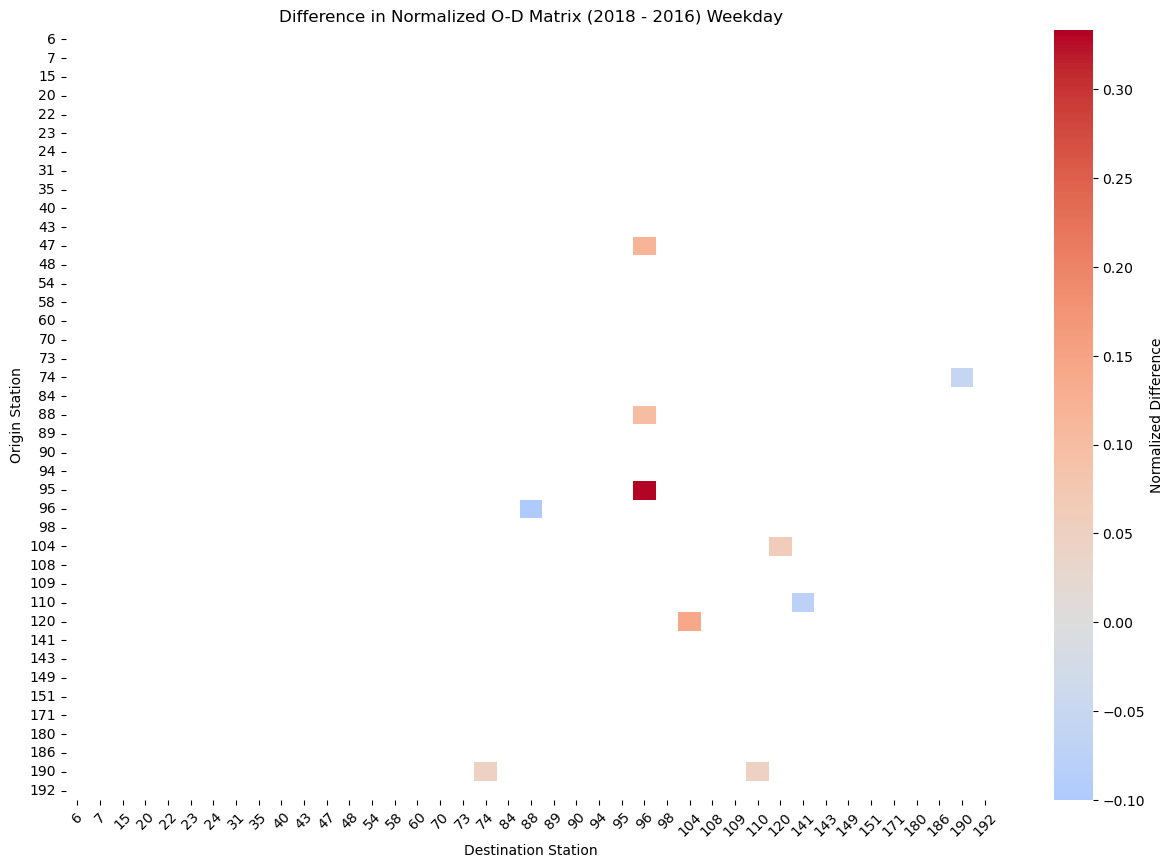

In [41]:
data_2016 = data_all_nice[(data_all_nice['year'] == 2016) & (data_all_nice['month'].isin([6, 13])) & (data_all_nice['hour'].isin(range(6, 23)))]
data_2018 = data_all_nice[(data_all_nice['year'] == 2018) & (data_all_nice['month'].isin([6, 13])) & (data_all_nice['hour'].isin(range(6, 23)))]

sp_trips_2016 = sp_trips_nice[(sp_trips_nice['year'] == 2016) & (sp_trips_nice['month'].isin([6, 13])) & (sp_trips_nice['hour'].isin(range(6, 23)))]
sp_trips_2018 = sp_trips_nice[(sp_trips_nice['year'] == 2018) & (sp_trips_nice['month'].isin([6, 13])) & (sp_trips_nice['hour'].isin(range(6, 23)))]

def aggregate_trips(data,all_data):
    trips = data.groupby(['start station id', 'end station id']).size().reset_index(name='trip_count')
    total_trips_by_station = all_data.groupby('start station id').size().reset_index(name='total_trips')
    trips = trips.merge(total_trips_by_station, on='start station id')
    trips['normalized_trip_count'] = trips['trip_count'] / trips['total_trips']
    return trips[['start station id', 'end station id', 'normalized_trip_count']]

trips_2016 = aggregate_trips(sp_trips_2016, data_2016)
trips_2018 = aggregate_trips(sp_trips_2018, data_2016)

def create_od_matrix(trips, stations, normalized_column):
    od_matrix = pd.DataFrame(0.0, index=stations, columns=stations)
    for _, row in trips.iterrows():
        od_matrix.loc[row['start station id'], row['end station id']] = row[normalized_column]
    return od_matrix

od_matrix_2016 = create_od_matrix(trips_2016, target_nodes, 'normalized_trip_count')
od_matrix_2018 = create_od_matrix(trips_2018, target_nodes, 'normalized_trip_count')

diff_od_matrix_normalized = od_matrix_2018 - od_matrix_2016
masked_diff_od_matrix = diff_od_matrix_normalized.replace(0, np.nan)

# Replace pd.NA with np.nan for compatibility with Seaborn
masked_diff_od_matrix = masked_diff_od_matrix.fillna(np.nan)

plt.figure(figsize=(15, 10))
sns.heatmap(masked_diff_od_matrix, cmap='coolwarm', center=0, annot=False, fmt='.2f', cbar_kws={'label': 'Normalized Difference'})
plt.title('Difference in Normalized O-D Matrix (2018 - 2016) Weekday')
plt.xlabel('Destination Station')
plt.ylabel('Origin Station')
plt.xticks(rotation=45)
plt.show()

In [42]:
# Count the number of pairs with values > 0 and < 0
positive_diff_count = (masked_diff_od_matrix > 0).sum().sum()
negative_diff_count = (masked_diff_od_matrix < 0).sum().sum()

print(f"Number of pairs with > 0 values: {positive_diff_count}")
print(f"Number of pairs with < 0 values: {negative_diff_count}")

Number of pairs with > 0 values: 7
Number of pairs with < 0 values: 3


In [43]:
origin_counts_2016 = sp_trips_2016['start station id'].value_counts().reset_index()
origin_counts_2016.columns = ['start_station_id', 'trip_count']

origin_counts_2018 = sp_trips_2018['start station id'].value_counts().reset_index()
origin_counts_2018.columns = ['start_station_id', 'trip_count']

top_5_most_popular_origins_2016 = origin_counts_2016.sort_values(by='trip_count', ascending=False).head(5)
top_5_least_popular_origins_2016 = origin_counts_2016.sort_values(by='trip_count', ascending=True).head(5)
top_5_most_popular_origins_2018 = origin_counts_2018.sort_values(by='trip_count', ascending=False).head(5)
top_5_least_popular_origins_2018 = origin_counts_2018.sort_values(by='trip_count', ascending=True).head(5)
print('Difference in the number of origin stations', len(origin_counts_2018) - len(origin_counts_2016))

print("Most Popular Origins in 2016:")
print(top_5_most_popular_origins_2016)

# print("\nTop 5 Least Popular Origins in 2016:")
# print(top_5_least_popular_origins_2016)

print("\nLeast Popular Origins in 2018:")
print(top_5_most_popular_origins_2018)

# print("\nTop 5 Least Popular Origins in 2018:")
# print(top_5_least_popular_origins_2018)

Difference in the number of origin stations 3
Most Popular Origins in 2016:
   start_station_id  trip_count
0                96           2
1                88           1
2               110           1
3                74           1

Least Popular Origins in 2018:
   start_station_id  trip_count
0                88           2
1               190           2
2                47           2
3                95           2
4               104           1


In [44]:
destination_counts_2016 = sp_trips_2016['end station id'].value_counts().reset_index()
destination_counts_2016.columns = ['end_station_id', 'trip_count']

destination_counts_2018 = sp_trips_2018['end station id'].value_counts().reset_index()
destination_counts_2018.columns = ['end_station_id', 'trip_count']

top_5_most_popular_destinations_2016 = destination_counts_2016.sort_values(by='trip_count', ascending=False).head(5)
top_5_least_popular_destinations_2016 = destination_counts_2016.sort_values(by='trip_count', ascending=True).head(5)
top_5_most_popular_destinations_2018 = destination_counts_2018.sort_values(by='trip_count', ascending=False).head(5)
top_5_least_popular_destinations_2018 = destination_counts_2018.sort_values(by='trip_count', ascending=True).head(5)
print('Difference in the number of destination stations', len(destination_counts_2018) - len(destination_counts_2016))

print("\nMost Popular Destinations in 2016:")
print(top_5_most_popular_destinations_2016)

# print("\nTop 5 Least Popular Destinations in 2016:")
# print(top_5_least_popular_destinations_2016)

print("\nLeast Popular Destinations in 2018:")
print(top_5_most_popular_destinations_2018)

Difference in the number of destination stations 2

Most Popular Destinations in 2016:
   end_station_id  trip_count
0              88           2
1              96           1
2             141           1
3             190           1

Least Popular Destinations in 2018:
   end_station_id  trip_count
0              96           6
1             110           1
2              74           1
3             120           1
4              88           1


In [45]:
# Flatten the difference O-D matrix
diff_flat = diff_od_matrix_normalized.unstack().reset_index()
diff_flat.columns = ['start_station_id', 'end_station_id', 'difference']

# Filter out zero differences for meaningful analysis
diff_flat_filtered = diff_flat[diff_flat['difference'] != 0]

# Sort by difference to get top 10 increasing and top 10 decreasing trips
top_increasing = diff_flat_filtered.sort_values(by='difference', ascending=False).head(3)
top_decreasing = diff_flat_filtered.sort_values(by='difference', ascending=True).head(3)

print("Top Increasing Trips:")
print(top_increasing)

print("\nTop Decreasing Trips:")
print(top_decreasing)

Top Increasing Trips:
      start_station_id  end_station_id  difference
1049                96              95    0.333333
1138               104             120    0.142857
1036                96              47    0.117647

Top Decreasing Trips:
      start_station_id  end_station_id  difference
845                 88              96   -0.100000
1342               141             110   -0.076923
1617               190              74   -0.055556


In [46]:
def analyze_trip_data(target_trip_count, station_id, years, dest, trip_direction, range_hours, weekend=False):

    station_column = 'start station id' if trip_direction == 'depart' else 'end station id'
    data_for_plot = []

    for year in years:
        filtered_data = target_trip_count[(target_trip_count[station_column].isin(station_id)) &
                                          (target_trip_count['hour'].isin(range_hours)) &
                                          (target_trip_count['year'] == year)]
        monthly_totals = filtered_data.groupby('month')['trip_count'].sum().reset_index()
        monthly_totals.columns = ['Month', 'Total Trips']
        trips_to_dest = filtered_data[filtered_data['end station id' if trip_direction == 'depart' else 'start station id'].isin(dest)]
        specific_destination_counts = trips_to_dest.groupby('month')['trip_count'].sum()
        monthly_totals['Specific Dest'] = specific_destination_counts.reset_index(drop=True)
        monthly_totals['% Specific Dest'] = np.round(monthly_totals['Specific Dest'] / monthly_totals['Total Trips'] * 100, 2)
        data_for_plot.append(monthly_totals)

    # Plotting
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    for data, year in zip(data_for_plot, years):
        ax1.plot(data['Month'], data['Total Trips'], marker='o', label=f'{year} - Total Trips')
        ax2.plot(data['Month'], data['% Specific Dest'], marker='o', label=f'{year} - % Specific Dest')

    ax1.set_xlabel('Month')
    ax1.set_ylabel('Total Trips')
    if weekend:
        ax1.set_title(f'Total Trips from Station(s) {station_id} : {min(range_hours)} - {max(range_hours)} h Weekend')

    else:
        ax1.set_title(f'Total Trips from Station(s) {station_id} : {min(range_hours)} - {max(range_hours)} h Weekday')
    ax1.legend()
    ax1.grid(True)
    ax1.set_xlim(6,12)

    ax2.set_xlabel('Month')
    ax2.set_ylabel('% Specific Destinations')
    if trip_direction == 'depart':
        ax2.set_title('% Trips From The Station(s) to Specific Destination(s)')
    else:
        ax2.set_title('% Trips To The Station(s) from Specific Destination(s)')
    ax2.legend()
    ax2.grid(True)
    ax2.set_xlim(6,12)

    plt.tight_layout()
    plt.show()

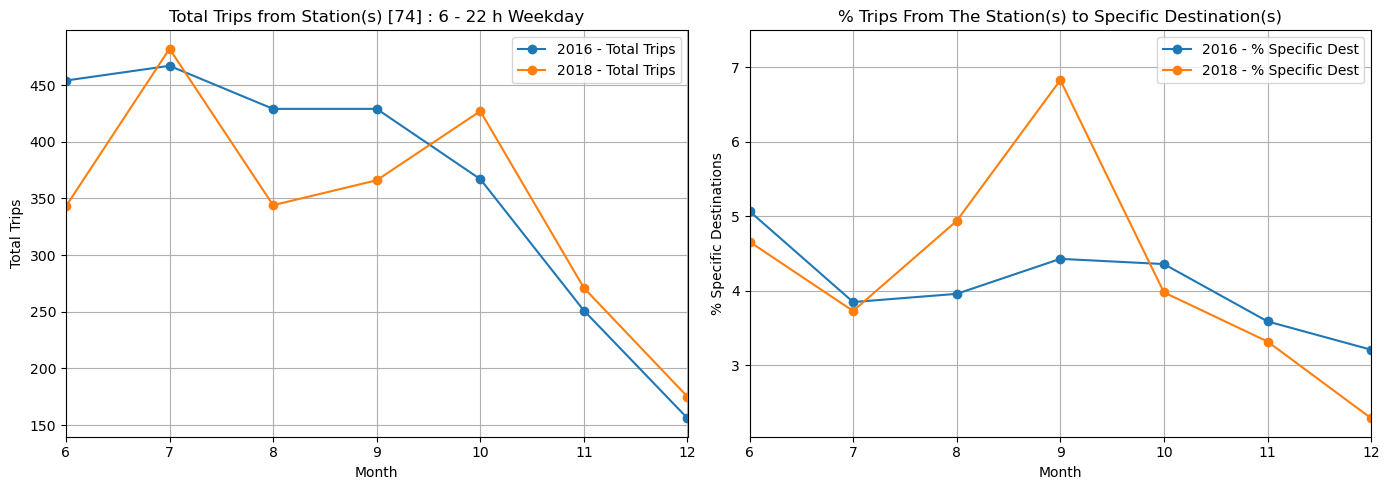

In [47]:
data_trip = tc2
years = [2016, 2018]
tn = [74]

dest = [95]

direction = 'depart'
# direction = 'arrive'

time_span = range(6,23) #hours
analyze_trip_data(data_trip, tn, years, dest, direction , time_span, weekend=False)

## Duration Analysis

In [48]:
side_1 = [88,95,225,90,143,182,190,109]
side_2 = [181,104,89,108,110]

In [49]:
def get_common_trips(data_after, data_before):
    common_trips = pd.merge(data_after, data_before, on=['start station id', 'end station id'], suffixes=('_after', '_before'))
    return common_trips.drop_duplicates()

def compare_trip_durations(common_trips):
    common_trips['duration_diff'] = common_trips['median duration_after'] - common_trips['median duration_before']
    common_trips['%_diff'] =  common_trips['duration_diff']/common_trips['median duration_before']*100
    return common_trips[['start station id', 'end station id', 'median duration_after', 'median duration_before', 'duration_diff', '%_diff']].drop_duplicates()


In [50]:
# def plot_trip_duration_histogram(df1, df2, stations, months, end_stations=side_2):

#     df1_morning_side1 = df1[(df1['start station id'].isin(stations))&(df1['end station id'].isin(end_stations))]
#     df2_morning_side1 = df2[(df2['start station id'].isin(stations))&(df2['end station id'].isin(end_stations))]
#     df1_morning_side1_copy = df1_morning_side1.copy()
#     df2_morning_side1_copy = df2_morning_side1.copy()

#     df1_morning_side1_copy['tripduration_minutes'] = df1_morning_side1_copy['tripduration'] / 60
#     df2_morning_side1_copy['tripduration_minutes'] = df2_morning_side1_copy['tripduration'] / 60

#     median_df1 = df1_morning_side1_copy['tripduration_minutes'].median()
#     median_df2 = df2_morning_side1_copy['tripduration_minutes'].median()


#     min_duration = min(df1_morning_side1_copy['tripduration_minutes'].min(), df1_morning_side1_copy['tripduration_minutes'].min())
#     max_duration = max(df1_morning_side1_copy['tripduration_minutes'].max(), df2_morning_side1_copy['tripduration_minutes'].max())
#     bins = np.linspace(min_duration, max_duration,15)

#     plt.figure(figsize=(10, 6))
#     plt.hist(df1_morning_side1_copy['tripduration_minutes'], bins=bins, edgecolor='black', alpha=0.5, label='2016', color='blue',density=True)
#     plt.hist(df2_morning_side1_copy['tripduration_minutes'], bins=bins, edgecolor='black', alpha=0.5, label='2018', color='red',density=True)
#     plt.axvline(median_df1, color='blue', linestyle='dashed', linewidth=2, label=f'2016 Median {np.round(median_df1,2)}')
#     plt.axvline(median_df2, color='red', linestyle='dashed', linewidth=2, label=f'2018 Median {np.round(median_df2,2)}')
#     title = f'Distribution of Trip Duration in Minutes for Stations: [{", ".join(map(str, stations))}], Month ({min(months)}-{max(months)})'
#     plt.title(title)
#     plt.xlabel('Trip Duration (minutes)')
#     plt.ylabel('Density')
#     plt.grid(True)
#     plt.legend()
#     plt.show()
#     return median_df1, median_df2

In [51]:
def plot_trip_duration(df1, df2, stations, months, end_stations=side_2):

    df1_morning_side1 = df1[(df1['start station id'].isin(stations)) & (df1['end station id'].isin(end_stations))]
    df2_morning_side1 = df2[(df2['start station id'].isin(stations)) & (df2['end station id'].isin(end_stations))]
    df1_morning_side1_copy = df1_morning_side1.copy()
    df2_morning_side1_copy = df2_morning_side1.copy()

    df1_morning_side1_copy['tripduration_minutes'] = df1_morning_side1_copy['tripduration'] / 60
    df2_morning_side1_copy['tripduration_minutes'] = df2_morning_side1_copy['tripduration'] / 60

    median_df1 = df1_morning_side1_copy['tripduration_minutes'].median()
    median_df2 = df2_morning_side1_copy['tripduration_minutes'].median()

    plt.figure(figsize=(10, 6))

    sns.kdeplot(df1_morning_side1_copy['tripduration_minutes'], color='blue', fill=True)
    sns.kdeplot(df2_morning_side1_copy['tripduration_minutes'], color='red', fill=True)

    plt.axvline(median_df1, color='blue', linestyle='dashed', linewidth=2, label=f'2016 Median {np.round(median_df1, 2)}')
    plt.axvline(median_df2, color='red', linestyle='dashed', linewidth=2, label=f'2018 Median {np.round(median_df2, 2)}')

    title = f'Distribution of Trip Duration in Minutes for Stations: [{", ".join(map(str, stations))}], Month ({min(months)}-{max(months)})'
    plt.title(title)
    plt.xlabel('Trip Duration (minutes)')
    plt.ylabel('Density')
    plt.grid(True)
    plt.legend()
    plt.show()

    return median_df1, median_df2

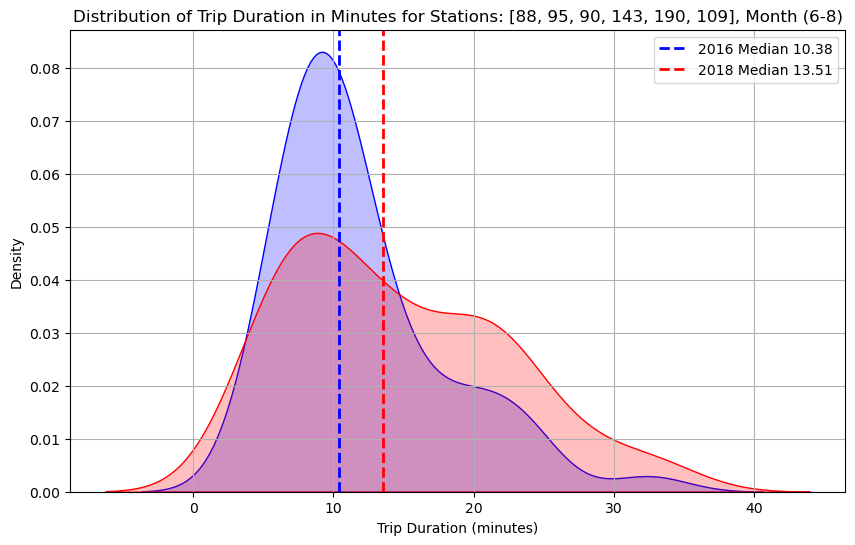

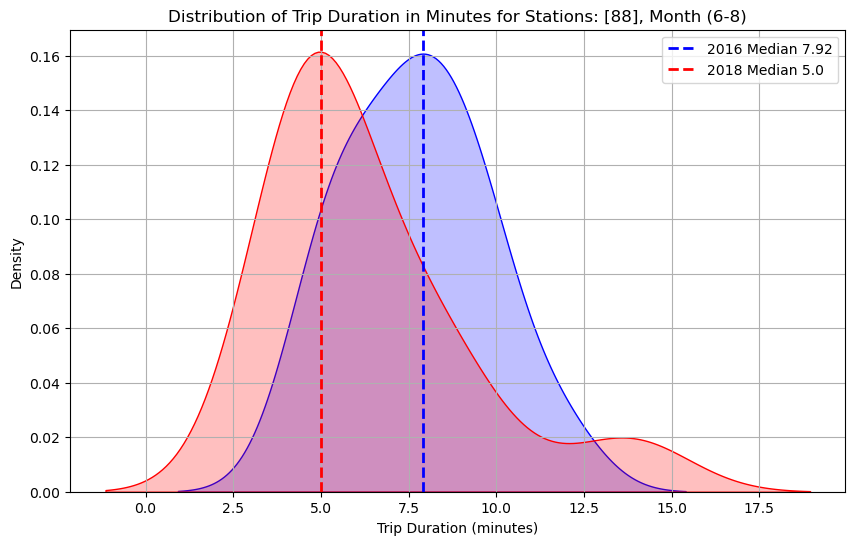

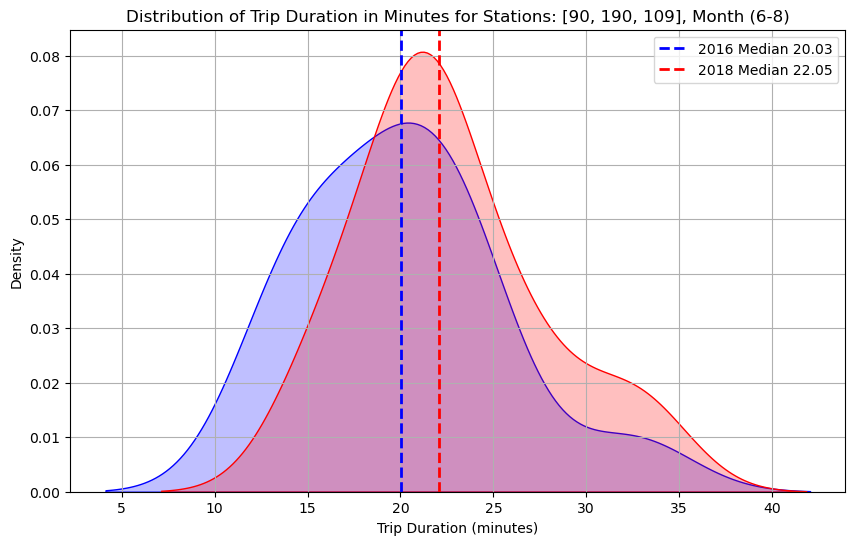

In [52]:
months = range(6,9)
fd1 = aggregate_time_groups(data_all, range(7,11), months,2016, median_calc=False)
fd2 = aggregate_time_groups(data_all, range(7,11), months,2018, median_calc=False)
total_stations =  [88,95,90,143,190,109]
close_stations =  [88]
far_stations =  [90,190,109]

med_total_before, med_total_after = plot_trip_duration(fd1, fd2, total_stations, months)
med_short_before, med_short_after = plot_trip_duration(fd1, fd2, close_stations, months)
med_long_before, med_long_after = plot_trip_duration(fd1, fd2, far_stations, months)

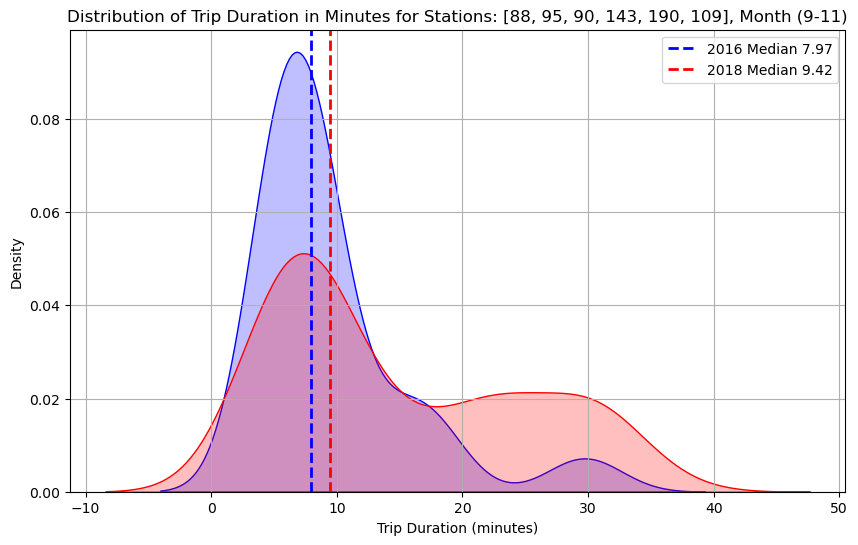

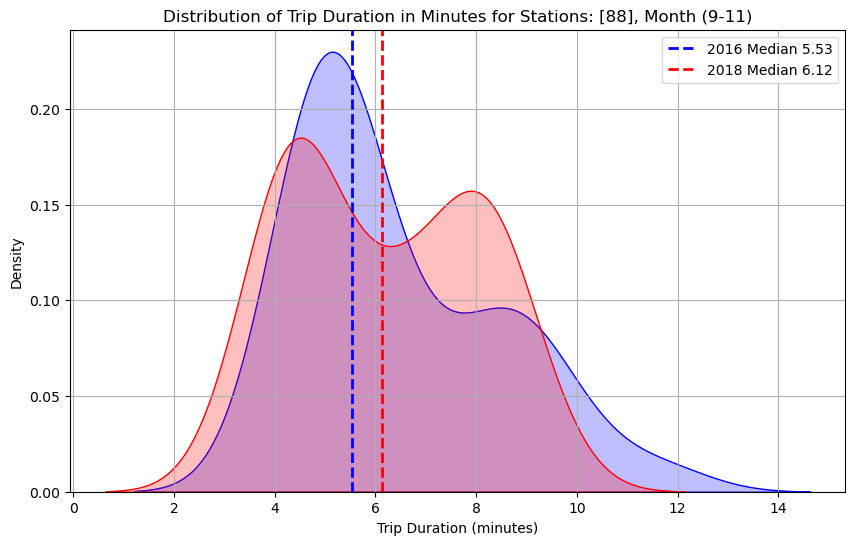

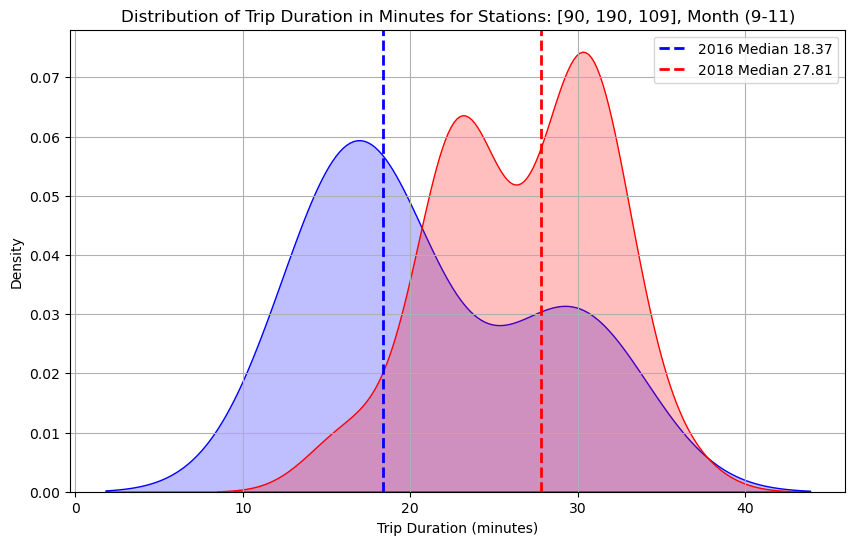

In [53]:
months = range(9,12)
fd1 = aggregate_time_groups(data_all, range(7,11), months,2016, median_calc=False)
fd2 = aggregate_time_groups(data_all, range(7,11), months,2018, median_calc=False)
total_stations =  [88,95,90,143,190,109]
close_stations =  [88]
far_stations =  [90,190,109]

med_total_before2, med_total_after2 = plot_trip_duration(fd1, fd2, total_stations, months)
med_short_before2, med_short_after2 = plot_trip_duration(fd1, fd2, close_stations, months)
med_long_before2, med_long_after2 = plot_trip_duration(fd1, fd2, far_stations, months)

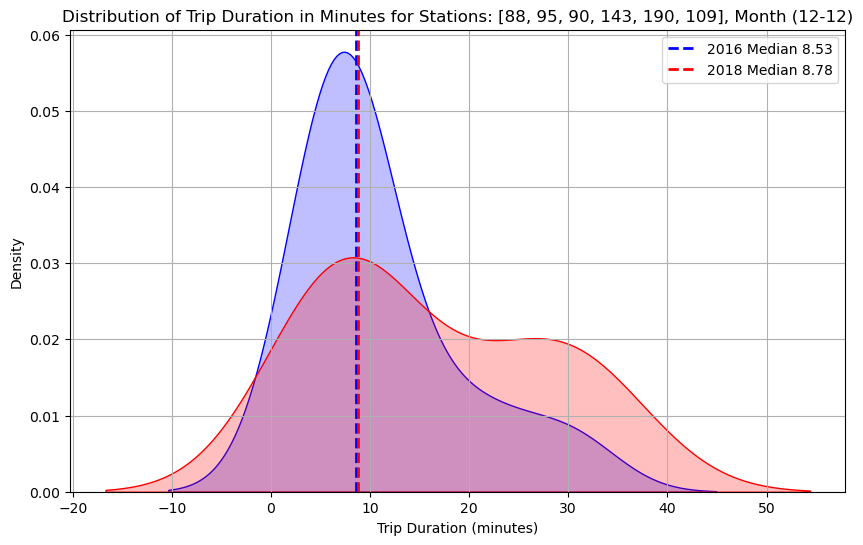

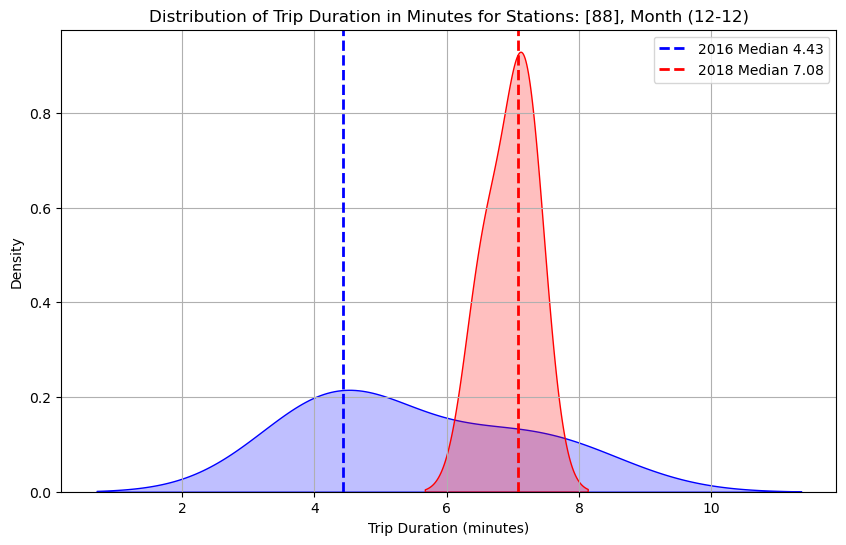

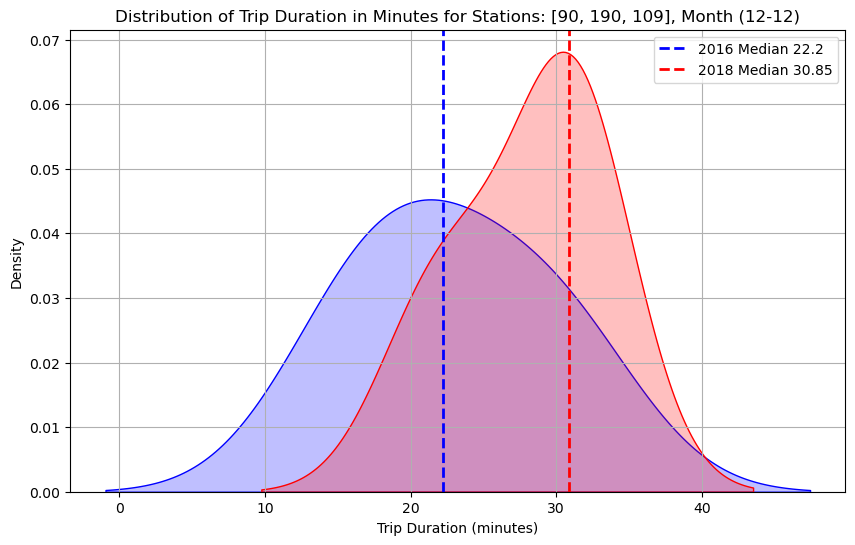

In [54]:
months = range(12,13)
fd1 = aggregate_time_groups(data_all, range(7,11), months,2016, median_calc=False)
fd2 = aggregate_time_groups(data_all, range(7,11), months,2018, median_calc=False)
total_stations =  [88,95,90,143,190,109]
close_stations =  [88]
far_stations =  [90,190,109]

med_total_before3, med_total_after3 = plot_trip_duration(fd1, fd2, total_stations, months)
med_short_before3, med_short_after3 = plot_trip_duration(fd1, fd2, close_stations, months)
med_long_before3, med_long_after3 = plot_trip_duration(fd1, fd2, far_stations, months)